# Classifying real vs. fake photons from $tt\gamma$, $t\bar{t}$ events

### no $\Delta R < 0.4$ cuts

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from coffea import hist, util
import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
import uproot

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

In [2]:
class PhotonSelector(processor.ProcessorABC):
    def __init__(self, isMC=True):
        
        # data is/isn't Monte-Carlo
        self.isMC = isMC

        # declare axes
        dataset_axis = hist.Cat("dataset","Dataset")

        photon_pt_axis = hist.Bin("pt","photon $p_{T}$ [GeV]", 40, 0, 400)
        photon_eta_axis = hist.Bin("eta","photon $\eta$", 50, -2.5, 2.5)
        photon_phi_axis = hist.Bin("phi","photon $\phi$", 64, -3.2, 3.2)
        photon_reliso_all_axis = hist.Bin("reliso","photon pfRelIso03_all", 40, -0.5, 6)
        photon_reliso_chg_axis = hist.Bin("reliso","photon pfRelIso03_chg", 40, -0.5, 6)
        photon_sieie_axis = hist.Bin("sieie","photon sigma I eta I eta", 40, 0, 0.05)
        photon_r9_axis = hist.Bin("r9","photon R9", 40, -0.5, 1.5)
        photon_hoe_axis = hist.Bin("hoe","photon H over E", 40, -0.5, 1)
        photon_count_axis = hist.Bin("count","Photon number",12,-1,10)

        deltar_axis = hist.Bin("deltar","$\Delta R$", 50, -0.5, 4)
        
        mvaid_axis = hist.Bin("mvaid", "mvaID", 25,-1,1)

        photon_genPartFlav_axis = hist.Bin("flav","genPartFlav",40,-1,15)
        
        
        # accumulator object: dictionary storing histograms & counters to be filled
        self._accumulator = processor.dict_accumulator({
            
            ## column accumulators
            'photon_pt': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_eta': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_phi': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_pfRelIso03_all': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_pfRelIso03_chg': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_sieie': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_r9': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_hoe': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_count': processor.column_accumulator(np.ndarray(shape=(0,))),
            
            'deltaR_photon_lepton': processor.column_accumulator(np.ndarray(shape=(0,))),
            'deltaR_photon_jet': processor.column_accumulator(np.ndarray(shape=(0,))),
            
            'photon_mvaid': processor.column_accumulator(np.ndarray(shape=(0,))),
            'file': processor.column_accumulator(np.ndarray(shape=(0,))),
            
            'photon_genPartFlav': processor.column_accumulator(np.ndarray(shape=(0,))),
            
            
            ## histograms for features
            'photon_pt_hist': hist.Hist("Counts", dataset_axis, photon_pt_axis),
            'photon_eta_hist': hist.Hist("Counts", dataset_axis, photon_eta_axis),
            'photon_phi_hist': hist.Hist("Counts", dataset_axis, photon_phi_axis),
            'photon_reliso_all_hist': hist.Hist("Counts", dataset_axis, photon_reliso_all_axis),
            'photon_reliso_chg_hist': hist.Hist("Counts", dataset_axis, photon_reliso_chg_axis),
            'photon_sieie_hist': hist.Hist("Counts", dataset_axis, photon_sieie_axis),
            'photon_r9_hist': hist.Hist("Counts", dataset_axis, photon_r9_axis),
            'photon_hoe_hist': hist.Hist("Counts", dataset_axis, photon_hoe_axis),
            'photon_count_hist': hist.Hist("Counts", dataset_axis, photon_count_axis),
            
            'deltaR_photon_lepton_hist': hist.Hist("Counts", dataset_axis, deltar_axis),
            'deltaR_photon_jet_hist': hist.Hist("Counts", dataset_axis, deltar_axis),
            
            'photon_mvaid_hist': hist.Hist("Counts", dataset_axis, mvaid_axis),
            
            'photon_genPartFlav_hist': hist.Hist("Counts", dataset_axis, photon_genPartFlav_axis),
        }
        )

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        
        output = self.accumulator.identity()
        dataset = events.metadata['dataset']
        
        ######## object & event selection ########
        # muons
        muons=events.Muon
        muonSelectTight = ((muons.pt>30) &
                           (abs(muons.eta)<2.4) &
                           (muons.tightId) &
                           (muons.pfRelIso04_all < 0.15)
                          )
        tightMuons = muons[muonSelectTight]
        
        # jets & b-tagged jets
        jets=events.Jet
        jetSelectTight = ((jets.pt>30) &
                          (abs(jets.eta)<2.4) &
                          (jets.isTight)
                         )
        btaggedJetSelect = (jetSelectTight &
                           (jets.btagDeepB>0.6321)
                          )
        tightJets = jets[jetSelectTight]
        tightBJets = jets[btaggedJetSelect]
        
        # electrons
        electrons=events.Electron
        electronSelectTight = ((electrons.pt> 35) &
                               (abs(electrons.eta)<2.1) &
                               electrons.cutBased>=4
                              )
        tightEle = electrons[electronSelectTight]
        
        
        # photons
        photons = events.Photon
        photonSelect= ((photons.pt>20) &
                       (abs(photons.eta) < 1.4442) &
                       (photons.isScEtaEE | photons.isScEtaEB) &
                       (photons.electronVeto) & 
                       np.invert(photons.pixelSeed)
                       )
        tightPhotons = photons[photonSelect]
        
        tightPhoMu, tightPhoMuDR = tightPhotons.nearest(tightMuons,return_metric=True)
        tightPhoJet, tightPhoJetDR = tightPhotons.nearest(tightJets,return_metric=True)
        
        
        # events
        trigger = events.HLT.IsoMu24 | events.HLT.IsoTkMu24
        
        eventSelection = (trigger &
                          (ak.num(tightMuons)==1) &
                          (ak.num(tightJets)>=4) & 
                          (ak.num(tightBJets)>=1) &
                          (ak.num(tightEle)==0) &
                          (ak.num(tightPhotons)>=1))

        
        # fill histograms
        output['photon_pt_hist'].fill(dataset=dataset,
                                      pt=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pt)))
        output['photon_eta_hist'].fill(dataset=dataset,
                                       eta=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].eta)))
        output['photon_phi_hist'].fill(dataset=dataset,
                                       phi=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].phi)))
        output['photon_reliso_all_hist'].fill(dataset=dataset,
                                              reliso=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pfRelIso03_all)))
        output['photon_reliso_chg_hist'].fill(dataset=dataset,
                                              reliso=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pfRelIso03_chg)))
        output['photon_sieie_hist'].fill(dataset=dataset,
                                         sieie=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].sieie)))
        output['photon_r9_hist'].fill(dataset=dataset,
                                      r9=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].r9)))
        output['photon_hoe_hist'].fill(dataset=dataset,
                                       hoe=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].hoe)))
        output['photon_count_hist'].fill(dataset=dataset,
                                         count=(ak.num(tightPhotons[eventSelection])))
        
        output['deltaR_photon_lepton_hist'].fill(dataset=dataset,
                                                 deltar=ak.to_numpy(ak.flatten(tightPhoMuDR[eventSelection])))
        output['deltaR_photon_jet_hist'].fill(dataset=dataset,
                                              deltar=ak.to_numpy(ak.flatten(tightPhoJetDR[eventSelection])))
        
        output['photon_mvaid_hist'].fill(dataset=dataset,
                                         mvaid=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].mvaID)))
        
        if self.isMC:
            output['photon_genPartFlav_hist'].fill(dataset=dataset,
                                                   flav=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].genPartFlav)))
        
        
        # fill column accumulators
        output['photon_pt'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.pt[eventSelection])))
        output['photon_eta'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.eta[eventSelection])))
        output['photon_phi'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.phi[eventSelection])))
        output['photon_pfRelIso03_all'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.pfRelIso03_all[eventSelection])))
        output['photon_pfRelIso03_chg'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.pfRelIso03_chg[eventSelection])))
        output['photon_sieie'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.sieie[eventSelection])))
        output['photon_r9'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.r9[eventSelection])))
        output['photon_hoe'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.hoe[eventSelection])))
        output['photon_count'] = processor.column_accumulator(ak.to_numpy(ak.num(tightPhotons[eventSelection])))
        
        output['deltaR_photon_lepton'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhoMuDR[eventSelection])))
        output['deltaR_photon_jet'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhoJetDR[eventSelection])))
        
        output['photon_mvaid'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.mvaID[eventSelection])))
        
        if self.isMC:
            output['photon_genPartFlav'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.genPartFlav[eventSelection])))
            
        # dataset labels
        if dataset=='TTGamma':
            output['file'] = processor.column_accumulator(np.ones_like(ak.to_numpy(ak.flatten(tightPhotons.pt[eventSelection]))))
        elif dataset=='TTbar':
            output['file'] = processor.column_accumulator(np.zeros_like(ak.to_numpy(ak.flatten(tightPhotons.pt[eventSelection]))))
        else:
            output['file'] = processor.column_accumulator(2*np.ones_like(ak.to_numpy(ak.flatten(tightPhotons.pt[eventSelection]))))
        
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [3]:
# Define files to run over
skimDir="/udrive/staff/dnoonan/Skims"

fileset = {"TTGamma":[f"{skimDir}/TTGamma_SingleLept_2016_skim.root"],
           "TTbar":[f"{skimDir}/TTbarPowheg_Semilept_2016_skim_1of10.root",
                    f"{skimDir}/TTbarPowheg_Semilept_2016_skim_2of10.root"],
          }
filesetData = {"DataMu":[f"{skimDir}/Data_SingleMu_b_2016_skim_1of10.root"],
              }

In [4]:
np.warnings.filterwarnings('ignore')

# The NanoAODSchema needs to be adjusted, to remove cross references to FSRPhotons
class SkimmedSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        super().__init__(base_form)

# Run Coffea code using uproot
outputMC = processor.run_uproot_job(
    fileset,  # Dictionary of datasets to run on
    "Events", # Name of the TTree to open
    PhotonSelector(),  # Coffea processor
    processor.futures_executor,
    executor_args={"schema": SkimmedSchema,'workers': 4},
    chunksize=1000000,
    #maxchunks=3,
)

Preprocessing:   0%|          | 0/3 [00:00<?, ?file/s]

Processing:   0%|          | 0/10 [00:00<?, ?chunk/s]

In [5]:
outputData = processor.run_uproot_job(
    filesetData,
    "Events",
    PhotonSelector(isMC=False),
    processor.futures_executor,
    executor_args={"schema": SkimmedSchema,'workers': 4},
    chunksize=1000000,
    #maxchunks=3,
)

Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/6 [00:00<?, ?chunk/s]

In [6]:
# scale MC luminosity to match data
nEvents = {}
for d in fileset:
    if not d in nEvents:
        nEvents[d] = 0
    for fName in fileset[d]:
        with uproot.open(fName)['hEvents'] as hEvents:
            nEvents[d] += hEvents.values()[0] + hEvents.values()[2]
cx = {'TTGamma':7.509,
     'TTbar': 380.095,
     'WGamma':489,
     'Z+jets':6077.22,
     'W+3jets':1165.8108,
     'W+4jets':592.9176}
lumi_weight = {}
for keyName in fileset:
    lumi_weight[keyName] = (cx[keyName]*450.)/nEvents[keyName]
    
for key, obj in outputMC.items():
    if isinstance(obj, hist.Hist):
        obj.scale(lumi_weight, axis="dataset")

In [7]:
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'k',
    'elinewidth': 1,
}

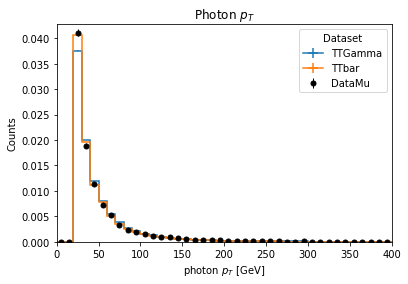

In [8]:
hist.plot1d(outputMC['photon_pt_hist'],overlay='dataset',stack=False,density=True)
hist.plot1d(outputData['photon_pt_hist'],overlay='dataset',error_opts=data_err_opts,stack=False,density=True)
plt.title("Photon $p_T$")
plt.show()

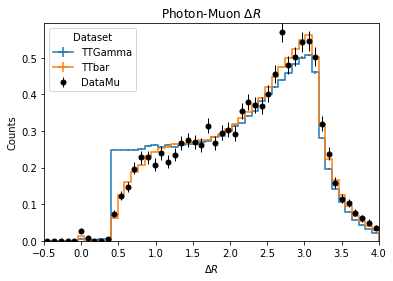

In [9]:
hist.plot1d(outputMC['deltaR_photon_lepton_hist'],overlay='dataset',stack=False,density=True)
hist.plot1d(outputData['deltaR_photon_lepton_hist'],overlay='dataset',error_opts=data_err_opts,stack=False,density=True)
plt.title("Photon-Muon $\Delta R$")
plt.show()

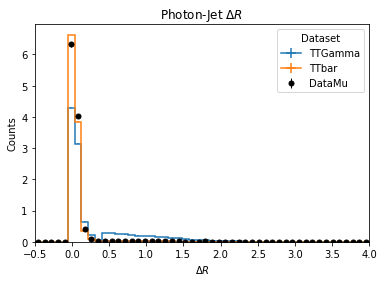

In [10]:
hist.plot1d(outputMC['deltaR_photon_jet_hist'],overlay='dataset',stack=False,density=True)
hist.plot1d(outputData['deltaR_photon_jet_hist'],overlay='dataset',error_opts=data_err_opts,stack=False,density=True)
plt.title("Photon-Jet $\Delta R$")
plt.show()

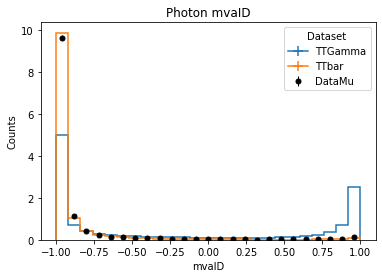

In [11]:
hist.plot1d(outputMC['photon_mvaid_hist'],stack=False,density=True)
hist.plot1d(outputData['photon_mvaid_hist'],overlay='dataset',error_opts=data_err_opts,stack=False,density=True)
plt.xlim(-1.1,1.1)
plt.title("Photon mvaID")
plt.show()

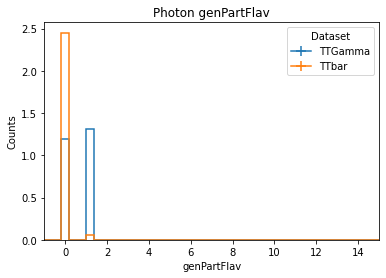

In [12]:
### label ###
hist.plot1d(outputMC['photon_genPartFlav_hist'],overlay='dataset',stack=False,density=True)
plt.title("Photon genPartFlav")
plt.show()

## Preprocessing data for training

In [13]:
print(np.array(outputMC['photon_count'].value).shape) # one entry per event, not per photon
print(np.array(outputMC['photon_pt'].value).shape)

(1088137,)
(1362199,)


In [14]:
df = pd.DataFrame({
    'photon_pt': np.array(outputMC['photon_pt'].value),
    'photon_eta': np.array(outputMC['photon_eta'].value),
    'photon_phi': np.array(outputMC['photon_phi'].value),
    'photon_hoe': np.array(outputMC['photon_hoe'].value),
    'photon_r9': np.array(outputMC['photon_r9'].value),
    'photon_sieie': np.array(outputMC['photon_sieie'].value),
    'photon_pfRelIso03_all': np.array(outputMC['photon_pfRelIso03_all'].value),
    'photon_pfRelIso03_chg': np.array(outputMC['photon_pfRelIso03_chg'].value),
    #'photon_count': np.array(outputMC['photon_count'].value),
    
    'deltaR_photon_lepton': np.array(outputMC['deltaR_photon_lepton'].value),
    'deltaR_photon_jet': np.array(outputMC['deltaR_photon_jet'].value),
    
    'file': np.array(outputMC['file'].value), # for MVA ID comparison, will remove from training set
    
    'photon_genPartFlav': np.array(outputMC['photon_genPartFlav'].value), ## TARGET ##
})

df.describe()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,file,photon_genPartFlav
count,1.362199e+06,1.362199e+06,1.362199e+06,1.362199e+06,1.362199e+06,1.362199e+06,1.362199e+06,1.362199e+06,1.362199e+06,1.362199e+06,1.362199e+06,1.362199e+06
mean,4.906322e+01,3.509713e-03,1.244407e-02,1.825232e-01,7.260739e-01,1.291205e-02,8.421103e-01,4.979452e-01,2.179716e+00,1.699817e-01,4.793463e-01,2.635562e-01
std,4.210622e+01,7.761611e-01,1.815535e+00,1.619427e-01,2.515710e-01,3.842901e-03,9.496977e-01,6.050608e-01,8.691922e-01,3.538638e-01,4.995734e-01,4.657082e-01
min,2.000001e+01,-1.444092e+00,-3.141602e+00,0.000000e+00,8.843994e-02,1.957417e-04,0.000000e+00,0.000000e+00,6.103516e-05,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.546105e+01,-6.296387e-01,-1.559814e+00,1.556396e-02,5.478516e-01,9.407043e-03,1.769875e-01,6.402592e-02,1.475775e+00,2.141247e-02,0.000000e+00,0.000000e+00
50%,3.477301e+01,8.710861e-03,1.387024e-02,1.738281e-01,7.490234e-01,1.229095e-02,5.840967e-01,3.181359e-01,2.314305e+00,4.039979e-02,0.000000e+00,0.000000e+00
75%,5.539150e+01,6.379395e-01,1.586426e+00,3.095703e-01,9.282227e-01,1.573181e-02,1.181197e+00,7.093032e-01,2.893131e+00,8.766920e-02,1.000000e+00,1.000000e+00
max,1.324450e+03,1.444092e+00,3.141602e+00,3.257812e+00,2.051562e+01,3.082275e-02,3.100977e+01,1.734663e+01,4.904033e+00,3.610590e+00,1.000000e+00,1.300000e+01


In [15]:
df['photon_genPartFlav'].value_counts()

0     1005571
1      356429
13        199
Name: photon_genPartFlav, dtype: int64

In [16]:
# relabel 13 (prompt electrons) as 0
df['photon_genPartFlav'] = df['photon_genPartFlav'].replace(13,0)
df.describe()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,file,photon_genPartFlav
count,1.362199e+06,1.362199e+06,1.362199e+06,1.362199e+06,1.362199e+06,1.362199e+06,1.362199e+06,1.362199e+06,1.362199e+06,1.362199e+06,1.362199e+06,1.362199e+06
mean,4.906322e+01,3.509713e-03,1.244407e-02,1.825232e-01,7.260739e-01,1.291205e-02,8.421103e-01,4.979452e-01,2.179716e+00,1.699817e-01,4.793463e-01,2.616571e-01
std,4.210622e+01,7.761611e-01,1.815535e+00,1.619427e-01,2.515710e-01,3.842901e-03,9.496977e-01,6.050608e-01,8.691922e-01,3.538638e-01,4.995734e-01,4.395370e-01
min,2.000001e+01,-1.444092e+00,-3.141602e+00,0.000000e+00,8.843994e-02,1.957417e-04,0.000000e+00,0.000000e+00,6.103516e-05,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.546105e+01,-6.296387e-01,-1.559814e+00,1.556396e-02,5.478516e-01,9.407043e-03,1.769875e-01,6.402592e-02,1.475775e+00,2.141247e-02,0.000000e+00,0.000000e+00
50%,3.477301e+01,8.710861e-03,1.387024e-02,1.738281e-01,7.490234e-01,1.229095e-02,5.840967e-01,3.181359e-01,2.314305e+00,4.039979e-02,0.000000e+00,0.000000e+00
75%,5.539150e+01,6.379395e-01,1.586426e+00,3.095703e-01,9.282227e-01,1.573181e-02,1.181197e+00,7.093032e-01,2.893131e+00,8.766920e-02,1.000000e+00,1.000000e+00
max,1.324450e+03,1.444092e+00,3.141602e+00,3.257812e+00,2.051562e+01,3.082275e-02,3.100977e+01,1.734663e+01,4.904033e+00,3.610590e+00,1.000000e+00,1.000000e+00


In [17]:
df['photon_genPartFlav'].value_counts()

0    1005770
1     356429
Name: photon_genPartFlav, dtype: int64

In [18]:
df.head()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,file,photon_genPartFlav
0,79.276085,-0.075348,-2.450684,0.164062,0.435791,0.014397,0.047569,0.023416,2.238493,0.011533,0.0,0
1,29.967369,-0.605591,-1.234375,0.307617,0.895508,0.018478,2.158426,1.643791,3.142428,0.010509,0.0,0
2,66.590996,1.353516,2.028320,0.145020,0.519531,0.010857,0.257907,0.114259,3.289150,0.023781,0.0,0
3,33.870628,0.123627,0.236298,0.281250,0.405762,0.011902,0.931639,0.849794,2.786459,0.316535,0.0,0
4,22.035528,-0.709961,-2.442871,0.267578,0.511230,0.010422,1.443260,0.963974,1.247723,0.066349,0.0,0


In [19]:
### split into train, val, test datasets ###

X = df.drop(['photon_genPartFlav'],axis=1)
y = df['photon_genPartFlav']

# shuffle & split into training, validation, testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)


In [20]:
# remove event type feature from datasets
file_test = X_test['file']

X_train = X_train.drop(['file'],axis=1)
X_test = X_test.drop(['file'],axis=1)
X_val = X_val.drop(['file'],axis=1)


In [21]:
# Scale: mean=0, stdev=1
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)


## Build & train model

In [22]:
model = Sequential()
model.add(Dense(32, input_shape=(X_train.shape[1],), activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                352       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit(X_train_scaled, y_train, epochs=5, batch_size=512)

Epoch 1/5
1597/1597 [==============================] - 4s 3ms/step - loss: 0.1637 - accuracy: 0.9385
Epoch 2/5
1597/1597 [==============================] - 5s 3ms/step - loss: 0.1284 - accuracy: 0.9523
Epoch 3/5
1597/1597 [==============================] - 4s 2ms/step - loss: 0.1236 - accuracy: 0.9541
Epoch 4/5
1597/1597 [==============================] - 5s 3ms/step - loss: 0.1209 - accuracy: 0.9550
Epoch 5/5
1597/1597 [==============================] - 4s 2ms/step - loss: 0.1194 - accuracy: 0.9554


In [24]:
loss, accuracy = model.evaluate(X_test_scaled,y_test,verbose=0)
print(f'Test loss: {round(loss,5)}\nTest accuracy: {round(accuracy,5)}')

Test loss: 0.11794
Test accuracy: 0.95606


In [25]:
y_pred = model.predict(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
area_under_curve = auc(fpr, tpr)

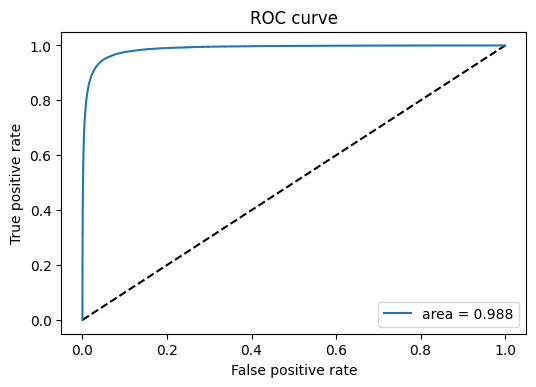

In [26]:
plt.figure(figsize=(6,4),dpi=100)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(area_under_curve))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [27]:
predTrue  = y_pred[y_test==True]
predFalse = y_pred[y_test==False]

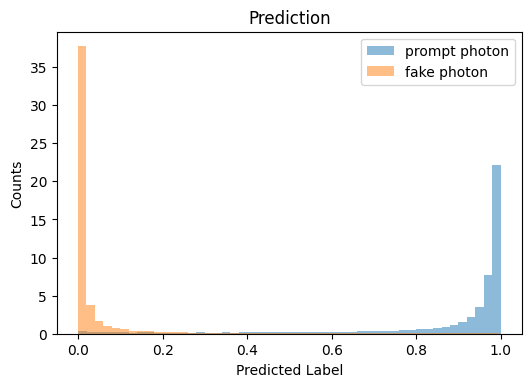

In [57]:
plt.figure(figsize=(6,4),dpi=100)

plt.hist(predTrue,bins=50,alpha=0.5,density=True,label='prompt photon')
plt.hist(predFalse,bins=50,alpha=0.5,density=True,label='fake photon')

plt.xlabel('Predicted Label')
plt.ylabel('Counts')
plt.title('Prediction')
plt.legend(loc='best')
plt.show()

In [54]:
## plot prediction distribution only for photons with DR > 0.4 ##

y_pred_cutDR = y_pred[(X_test["deltaR_photon_lepton"] > 0.4) & (X_test["deltaR_photon_jet"] > 0.4)]
y_test_cutDR = y_test[(X_test["deltaR_photon_lepton"] > 0.4) & (X_test["deltaR_photon_jet"] > 0.4)]

predTrue_cutDR  = y_pred_cutDR[y_test_cutDR==True]
predFalse_cutDR = y_pred_cutDR[y_test_cutDR==False]

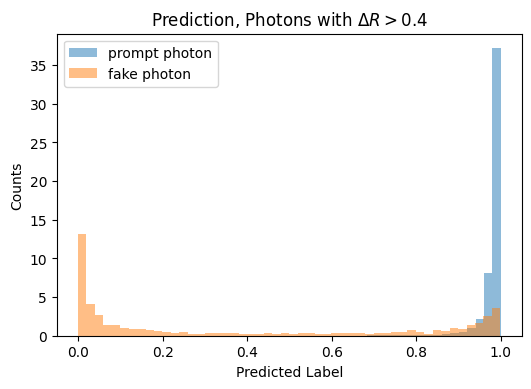

In [58]:
plt.figure(figsize=(6,4),dpi=100)

plt.hist(predTrue_cutDR,bins=50,alpha=0.5,density=True,label='prompt photon')
plt.hist(predFalse_cutDR,bins=50,alpha=0.5,density=True,label='fake photon')

plt.xlabel('Predicted Label')
plt.ylabel('Counts')
plt.title('Prediction, Photons with $\Delta R > 0.4$')
plt.legend(loc='best')
plt.show()

### Evaluate the model on data

In [29]:
X_data = pd.DataFrame({
    'photon_pt': np.array(outputData['photon_pt'].value),
    'photon_eta': np.array(outputData['photon_eta'].value),
    'photon_phi': np.array(outputData['photon_phi'].value),
    'photon_hoe': np.array(outputData['photon_hoe'].value),
    'photon_r9': np.array(outputData['photon_r9'].value),
    'photon_sieie': np.array(outputData['photon_sieie'].value),
    'photon_pfRelIso03_all': np.array(outputData['photon_pfRelIso03_all'].value),
    'photon_pfRelIso03_chg': np.array(outputData['photon_pfRelIso03_chg'].value),
    #'photon_count': np.array(outputData['photon_count'].value),
    
    'deltaR_photon_lepton': np.array(outputData['deltaR_photon_lepton'].value),
    'deltaR_photon_jet': np.array(outputData['deltaR_photon_jet'].value),
})

X_data.describe()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet
count,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000
mean,48.844124,-0.001477,-0.006091,0.223218,0.672649,0.013949,1.040128,0.601470,2.249400,0.068099
std,42.629852,0.792872,1.815690,0.155518,0.259802,0.003653,0.972655,0.627394,0.855156,0.166884
min,20.002771,-1.443604,-3.140625,0.000000,0.125732,0.003870,0.000000,0.000000,0.002021,0.000427
25%,24.961231,-0.661133,-1.582153,0.085693,0.501465,0.010864,0.399883,0.188194,1.587928,0.019248
50%,33.986900,-0.000775,0.015211,0.221680,0.672852,0.013824,0.780743,0.426636,2.383305,0.034804
75%,54.494076,0.650574,1.552979,0.343750,0.834473,0.016541,1.361864,0.818062,2.926016,0.060586
max,599.480103,1.443359,3.140137,1.355469,6.789062,0.026962,13.611495,7.809951,4.723557,2.619408


In [30]:
scaler = StandardScaler()
X_data_scaled = scaler.fit_transform(X_data)

In [31]:
y_pred_data = model.predict(X_data_scaled)

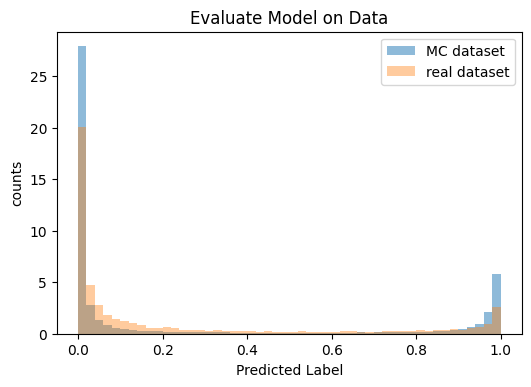

In [32]:
plt.figure(figsize=(6,4),dpi=100)

plt.hist(y_pred,bins=50,alpha=0.5,density=True,label="MC dataset")
plt.hist(y_pred_data,bins=50,alpha=0.4,density=True,label="real dataset")

plt.xlabel("Predicted Label")
plt.ylabel("counts")
plt.title("Evaluate Model on Data")
plt.legend()
plt.show()

### Compare mvaID

In [33]:
# separate y_pred by dataset
y_pred_ttg = y_pred[file_test==1]
y_pred_ttb = y_pred[file_test==0]

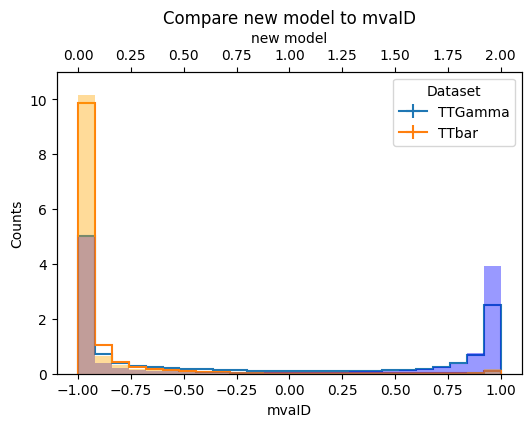

In [34]:
fig, ax1 = plt.subplots(figsize=(6,4),dpi=100)

hist.plot1d(outputMC['photon_mvaid_hist'],stack=False,density=True,ax=ax1)
ax1.set_xlim(-1.1,1.1)

ax2 = ax1.twiny()
ax2.hist(2*y_pred_ttg,bins=25,density=True,alpha=0.4,color="blue")
ax2.hist(2*y_pred_ttb,bins=25,density=True,alpha=0.4,color="orange")
ax2.set_xlabel("new model")

plt.ylim(0,11)
plt.title("Compare new model to mvaID")
plt.show()

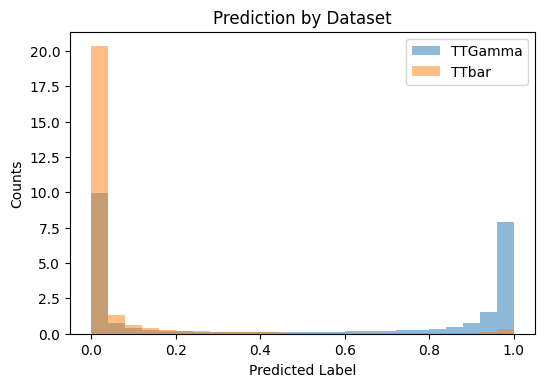

In [35]:
# just new model
plt.figure(figsize=(6,4),dpi=100)

plt.hist(y_pred_ttg,bins=25,density=True,alpha=0.5,label="TTGamma")
plt.hist(y_pred_ttb,bins=25,density=True,alpha=0.5,label="TTbar")

plt.xlabel("Predicted Label")
plt.ylabel("Counts")
plt.title("Prediction by Dataset")
plt.legend()
plt.show()

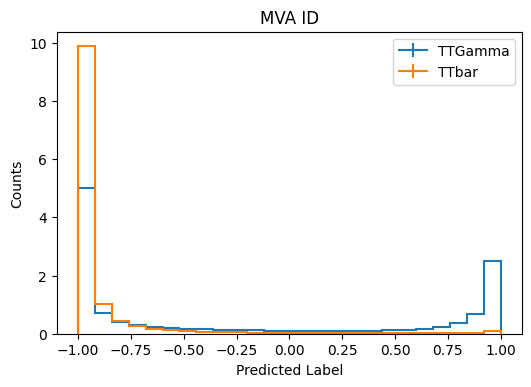

In [36]:
# just MVA ID
plt.figure(figsize=(6,4),dpi=100)

hist.plot1d(outputMC['photon_mvaid_hist'],stack=False,density=True)
plt.xlim(-1.1,1.1)

plt.xlabel("Predicted Label")
plt.ylabel("Counts")
plt.title("MVA ID")
plt.legend()
plt.show()